In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# import the required libraries
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import layers, models
from google.colab.patches import cv2_imshow
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
import cv2

In [0]:
# define variables
RESIZE = 0.5
EPOCHS = 10
LEARNING_RATE = 0.001

In [0]:
def get_data():

    data = []
    parts = ['part1', 'part2']

    for part in parts:

        print(f'Fetching data from {part}')

        files = os.listdir(f'drive/My Drive/nfsmw/{part}/')
        for count, f in enumerate(files):
            
            if count % 50 == 0:
                print(f'Fetched {count} files')
            
            image = cv2.imread(f'/content/drive/My Drive/nfsmw/{part}/{f}')
            image = cv2.resize(image, None, fx=RESIZE, fy=RESIZE)
            label = f.split('-')[1].split('.')[0]
            
            if label == 'straight':
                label = 0
            elif label == 'left':
                label = 1
            elif label == 'right':
                label = 2
            
            data.append( [image, label] )
    
    return np.array(data)

In [123]:
# prepare the data

# fetch the data
data = get_data()

# shuffle the data to create some randomness
np.random.shuffle(data)

# normalize the images
images = np.array( [d[0] for d in data] )
images = images / 255

# get the labels for the images
labels = np.array( [d[1] for d in data] )

# divide the data into training and testing data
# keep the ratio at 70% to 30%
div = int( len(labels) * 0.7 )
train_images = images[:div]
train_labels = labels[:div]
test_images = images[div:]
test_labels = labels[div:]

Fetching data from part1
Fetched 0 files
Fetched 50 files
Fetched 100 files
Fetched 150 files
Fetched 200 files
Fetching data from part2
Fetched 0 files
Fetched 50 files
Fetched 100 files
Fetched 150 files
Fetched 200 files


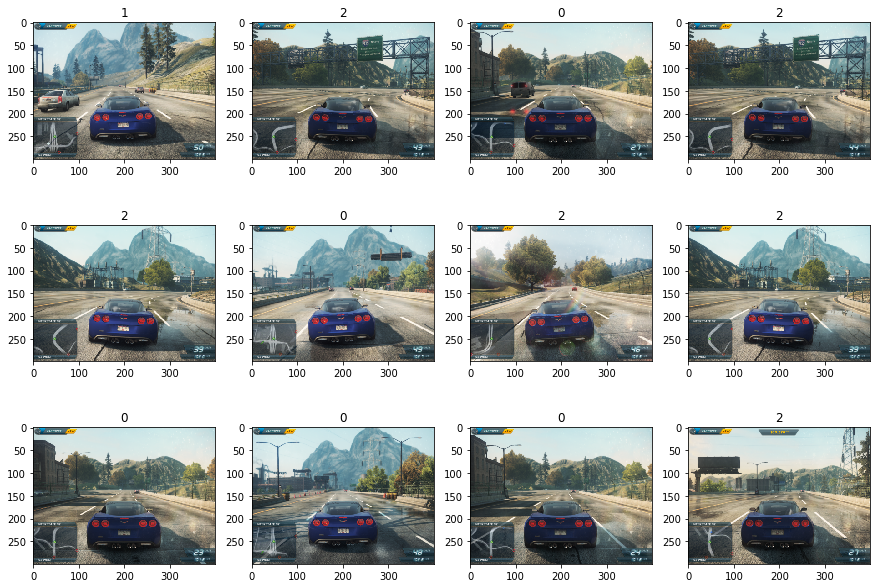

In [124]:
# graphics
plt.figure( figsize=(15, 18) )
for i in range(12):
    plt.subplot(5, 4, i+1)
    plt.title(train_labels[i])
    plt.imshow(train_images[i][:,:,::-1])

In [125]:
# get the input shape
input_shape = train_images[0].shape

# create a convolutional neural network base
model = models.Sequential(name='sdc_cnn_model')

model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=input_shape, name='first_conv2d'))
model.add(layers.MaxPooling2D((3, 3), name='first_maxpooling'))
model.add(layers.Conv2D(64, (5, 5), activation='relu', name='second_conv2d'))
model.add(layers.MaxPooling2D((3, 3), name='second_maxpooling'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='third_conv2d'))

# add dense layers on the top
model.add(layers.Flatten(name='flatten_layer'))
model.add(layers.Dense(64, activation='relu', name='relu_layer'))
model.add(layers.Dense(3, activation='softmax', name='softmax_layer'))

# get the model's summary to validate the model architecture
model.summary()

# compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=EPOCHS, 
                    validation_data=(test_images, test_labels))

# save the model
model.save('sdc-cnn-model.h5')

Model: "sdc_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv2d (Conv2D)        (None, 294, 394, 32)      4736      
_________________________________________________________________
first_maxpooling (MaxPooling (None, 98, 131, 32)       0         
_________________________________________________________________
second_conv2d (Conv2D)       (None, 94, 127, 64)       51264     
_________________________________________________________________
second_maxpooling (MaxPoolin (None, 31, 42, 64)        0         
_________________________________________________________________
third_conv2d (Conv2D)        (None, 29, 40, 64)        36928     
_________________________________________________________________
flatten_layer (Flatten)      (None, 74240)             0         
_________________________________________________________________
relu_layer (Dense)           (None, 64)              

132/132 - 0s - loss: 0.1190 - acc: 0.9697
Accuracy: 0.9696969985961914


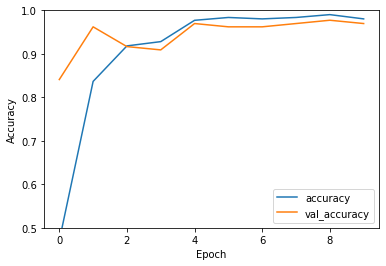

In [126]:
# evaluate the model
plt.plot( history.history['acc'], label='accuracy' )
plt.plot( history.history['val_acc'], label = 'val_accuracy' )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim( [0.5, 1] )
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print(f'Accuracy: {test_acc}')

plt.show()